In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Functions for report

In [5]:
df = pd.read_csv('sensor_data_11-29.csv')
df.head()

def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()





,Timestamp,Sensor1,Sensor2,BreathRate1,BreathRate2,FusedBreathRate
0,249.0,239,1,1.415094,0.283019,1.415094
1,250.0,240,1,1.415094,0.283019,1.415094
2,251.0,240,1,1.415094,0.283019,1.415094
3,252.0,238,1,1.415094,0.283019,1.415094
4,253.0,239,1,1.415094,0.283019,1.415094


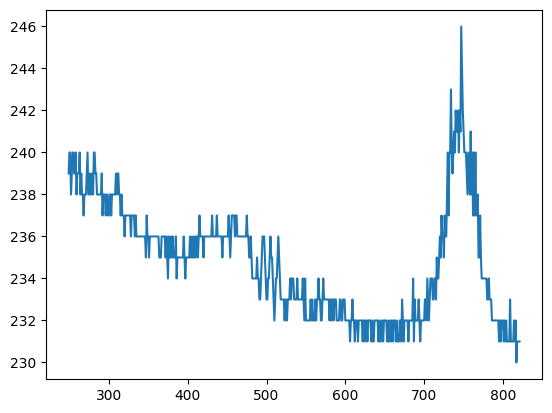

In [6]:
plt.plot(df['Timestamp'], df['Sensor1'])


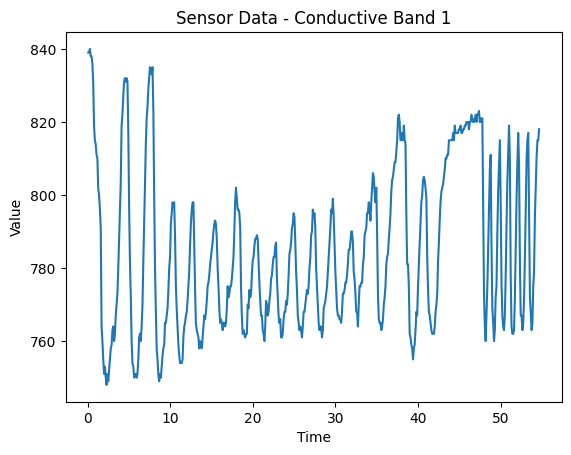

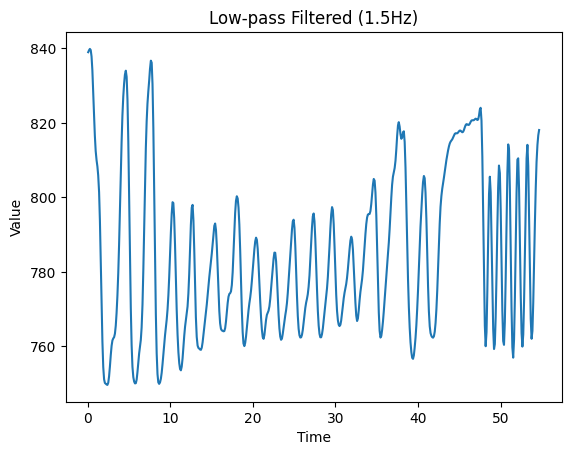

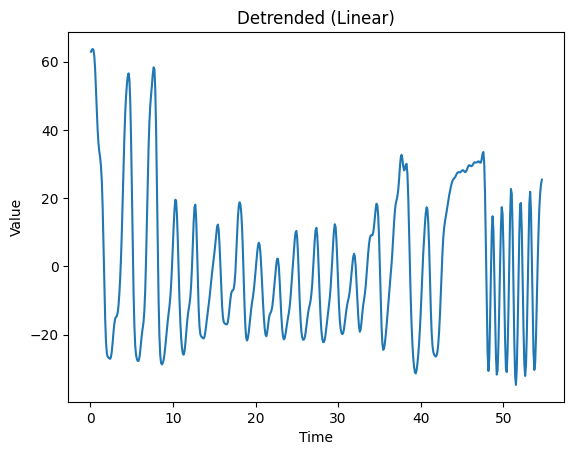

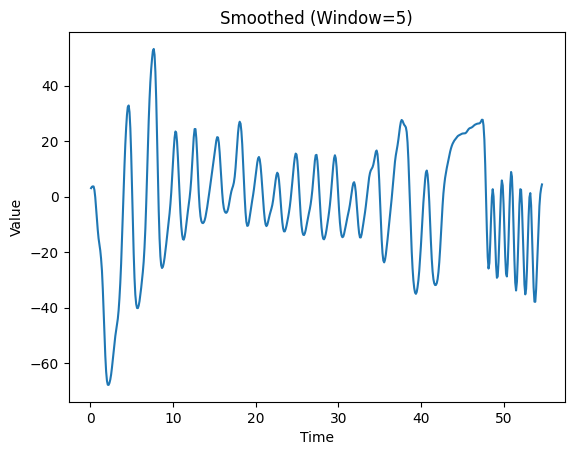

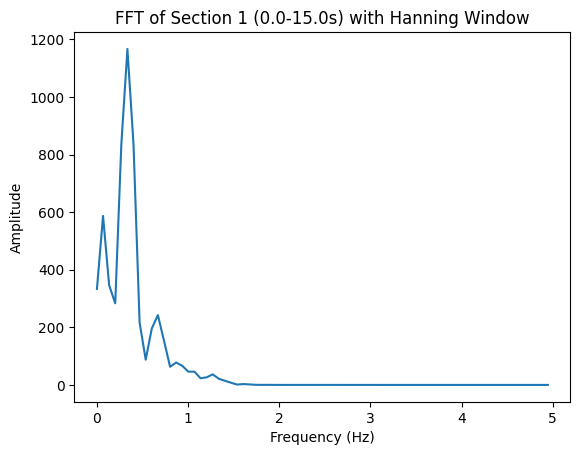

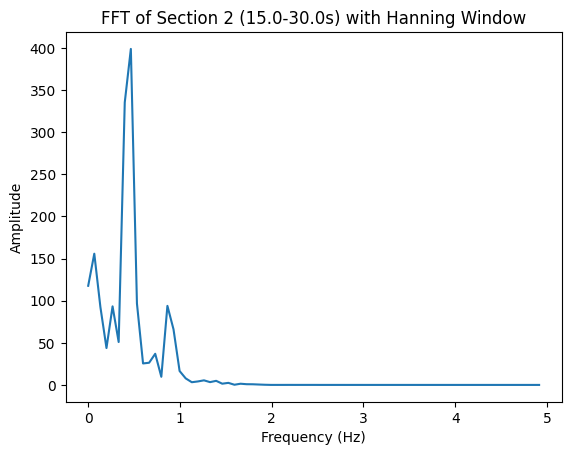

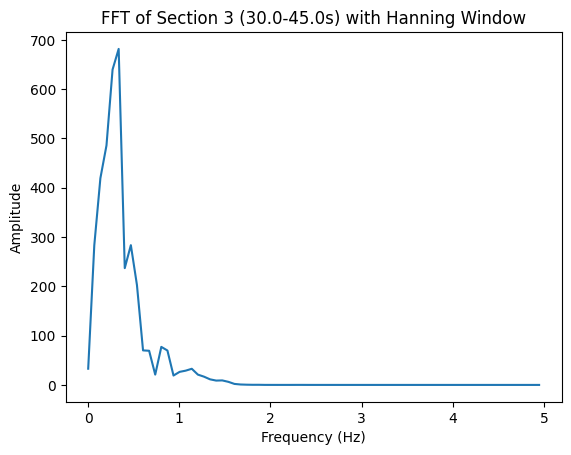

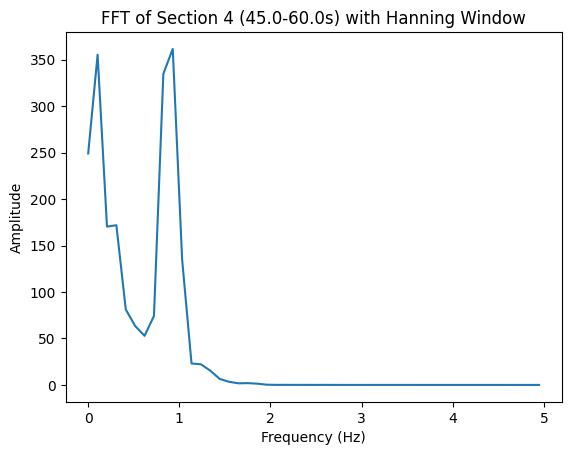

In [7]:
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import detrend

df_band1 = pd.read_csv('sensor_data_conductive_band_1.csv')
plt.plot(df_band1['time'], df_band1['value'])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Sensor Data - Conductive Band 1')
plt.show()
# Sampling frequency estimation
dt = np.diff(df_band1['time']).mean()
fs = 1 / dt

# Butterworth filter design
def butter_filter(data, cutoff, fs, btype, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return filtfilt(b, a, data)

# 1. Low-pass filter at 1.5Hz
low_passed = butter_filter(df_band1['value'], 1.5, fs, 'low')
plt.figure()
plt.plot(df_band1['time'], low_passed)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Low-pass Filtered (1.5Hz)')
plt.show()

# 2. Detrend using scipy.signal.detrend (removes linear trend)
detrended = detrend(low_passed)
plt.figure()
plt.plot(df_band1['time'], detrended)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Detrended (Linear)')
plt.show()

# 3. Smoothing with window of 5
smoothed = pd.Series(high_passed).rolling(window=5, center=True, min_periods=1).mean()
plt.figure()
plt.plot(df_band1['time'], smoothed)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Smoothed (Window=5)')
plt.show()

# 4. FFT visualization for each 15s section
section_length = 15  # seconds
n_sections = int(np.ceil(df_band1['time'].iloc[-1] / section_length))

for i in range(n_sections):
    start_time = i * section_length
    end_time = (i + 1) * section_length
    mask = (df_band1['time'] >= start_time) & (df_band1['time'] < end_time)
    section = smoothed[mask]
    if len(section) < 2:
        continue
    section_time = df_band1['time'][mask]
    section_vals = section.values
    n = len(section_vals)
    # Apply a Hanning window
    window = np.hanning(n)
    windowed_vals = (section_vals - np.mean(section_vals)) * window
    yf = np.fft.rfft(windowed_vals)
    xf = np.fft.rfftfreq(n, d=dt)
    plt.figure()
    plt.plot(xf, np.abs(yf))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title(f'FFT of Section {i+1} ({start_time:.1f}-{end_time:.1f}s) with Hanning Window')
    plt.show()